# microCOSM Model ensemble

<img src="boxmodel_schematic.png" width="350" />

The _microCOSM_ model has three boxes linked by an overturning circulation: a cool, fresh, upwelling box with low iron input analagous to HNLC regions like the Southern Ocean, and a warmer, salty, deep water formation region with significant iron input analagous to the Atlantic Ocean. Iron-binding ligands are produced by organic matter turnover, and lost by microbial degradation (Lauderdale et al, 2020, doi:10.1073/pnas.1917277117).

In this notebook, we run two groups of simulations looking at the response of the global carbon cycle to changes in overturning circulation strength, additionally considering the effects of constant, fixed iron-ligand concentrations and dynamic ligand cycling.

In [4]:
import glob              as gb
import matplotlib        as mp
import matplotlib.pyplot as plt
import numpy             as np
import numpy.ma          as nm
import pandas            as pd
import warnings          as ws

# Some figure options for later
mp.rcParams["xtick.labelsize"] = 14
mp.rcParams["ytick.labelsize"] = 14


def compile_microcosm(options=None):
    # Function to help compile the microCOSM box model
    # Supply compile options as a list of the following:
    #    FIXATMPCO2 - disable the conservative atmospheric carbon box
    #    WRITEOUTFILE - enable the textfile output.
    # NOTE: you have to restart the kernal if you change these options and recompile
    #       more than once...limitation of using f2py
    import os
    import subprocess

    # Depending on platform
    if os.sys.platform == "darwin":
        # Issue with compilation where f2py is linking to v10.9 rather than current OSX version.
        import platform

        mac_ver = ".".join(platform.mac_ver()[0].split(".")[:2])
        env = dict(os.environ, **{"MACOSX_DEPLOYMENT_TARGET": mac_ver})
        print("setting MACOSX_DEPLOYMENT_TARGET to: " + mac_ver)
    else:
        env = os.environ

    optdefs = "OPTIONDEFS = "
    if options is not None:
        optdefs = optdefs + " ".join(["-D" + item for item in options])
        print("Compiling with options: " + optdefs)

    # Clean environment of previous model files
    runmake = subprocess.Popen(
        ["make", "clean"],
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,
        env=env,
    )
    runmake.wait()
    # Compile 
    runmake = subprocess.Popen(
        ["make", "pymodel", optdefs],
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,
        env=env,
    )
    runmake.wait()
    print("The exit code for compilations was: %d" % runmake.returncode)
    return runmake.returncode


def check_parallel():
    import importlib

    spec = importlib.util.find_spec("pandarallel")
    run_in_parallel = spec is not None
    return run_in_parallel

## 1. Run a small ensemble in parallel to examine sensitivity
It's possible to use _microCOSM_ to perform efficient ensemble/parameter space exploration (potentially in parallel using the "Pandarallel" package's "parallel_apply" function). This separate notebook is necessary because you cannot 'reload' f2py extension modules

First, recompile the model to allow variable atmospheric pCO$_2$ (sometimes this seems to just hang?)

In [15]:
ec = compile_microcosm()  # no options

if ec == 0:
    import microCOSM

setting MACOSX_DEPLOYMENT_TARGET to: 12.5
The exit code for compilations was: 0


Define some driver functions for running the ensemble

In [3]:
def run_microcosm(df_input, workers=1, Rcp=106, Rnp=16):
    """
    Run the box model:

    a) workers=1; in series using pandas' "apply" to run through rows of a data frame of inputs
    b) workers>1; in parallel using pandarallel's "parallel_apply"

    returns pandas dataframe with the results
    """
    # Define private helper function, pretty much the same as the direct model call in "run_microCOSM" notebook
    def _boxmodel(self):
        timeseries = pd.DataFrame(
            np.column_stack(
                microCOSM.mod_modelmain.model(*self.values),
                            ).T,
                            index=[
                                "time",
                                "tso",
                                "tna",
                                "tdo",
                                "sso",
                                "sna",
                                "sdo",
                                "cso",
                                "cna",
                                "cdo",
                                "aso",
                                "ana",
                                "ado",
                                "pso",
                                "pna",
                                "pdo",
                                "nso",
                                "nna",
                                "ndo",
                                "fso",
                                "fna",
                                "fdo",
                                "lso",
                                "lna",
                                "ldo",
                                "exportso",
                                "exportna",
                                "exportdo",
                                "lim",
                                "pstar",
                                "pco2so",
                                "pco2na",
                                "pco2do",
                                "atmpco2",
                                    ],
                              ).transpose()

        # return the last timestep of model run, as well as input parameter values
        return pd.concat(
                [
                    self[["niter",
                          "nyrs",
                          "tout",
                          "nout",
                          "psi",
                          "dif",
                          "alphabio",  
                          "gamma",     
                          "lambda",    
                    #      "dlambdadz", 
                    #      "sourceFe",  
                    #      "wind",      
                    #      "fopen",
                         ]],
                    timeseries.iloc[-1].drop(columns=["time"]),
                    ]
                    )   

    if workers == 1:
        # Run in serial mode (avoids overhead of pandarallel if not running multiprocessor)
        df_output = df_input.apply(_boxmodel, axis=1)
    elif workers > 1:
        # Run in parallel
        from pandarallel import pandarallel

        pandarallel.initialize(nb_workers=workers, progress_bar=True)

        df_output = df_input.parallel_apply(_boxmodel, axis=1)

    # Do some post processing
    df_output = postprocessing(df_output, Rcp=Rcp)

    return df_output


# example post processing routine
def postprocessing(data_pd, Rcp=106):
    # Integrated export production (Southern Ocean + North Atlantic)
    data_pd["tot_export"] = data_pd["exportso"] + data_pd["exportna"]
    return data_pd

Set up the model ensemble investigating how the strength of the overturning circulation affects atmospheric CO$_2$ levels. First, we'll start with fixed and homogenous ligand concentrations.

In [4]:
# Set psi max
psi_max = 70.0
# psi_max=320.

# Name mangling to get the right pickup
fadd = ""

# Number of experiments to run
niters = 36
# niters = 65
niter = np.arange(niters)

fnadd = fadd + "fixedlt2nm"

# Load steady state values from before
model_input = pd.read_json("run_microCOSM_" + fnadd + "_pickup.json", typ='series').to_frame()

# change overturning circulation by 2Sv between 0 and 40Sv
psi_var = np.linspace(0.0, psi_max, niters) * 1e6

# repeat the input parameters and adjust for the ensemble run
ensemble1_input = pd.concat([model_input.T] * niters, ignore_index=True, copy=True)

ensemble1_input["nyrs"]   = 1e4
ensemble1_input["tout"]   = 10
ensemble1_input["nout"]   = int(ensemble1_input["nyrs"].iloc[0]/ensemble1_input["tout"].iloc[0])
ensemble1_input["psi"]    = psi_var
ensemble1_input["niter"]  = niter
#ensemble1_input["sFetop"] = 0.125
#ensemble1_input["sFebot"] = 0.0

ensemble1_input.to_json(
    "run_microCOSM_" + fnadd + "_psi_{:.0f}Sv".format(psi_max) + "_input.json"
)
ensemble1_input.iloc[0]

niter                                                         0
nyrs                                                    10000.0
tout                                                         10
nout                                                       1000
dx                         [17000000.0, 17000000.0, 17000000.0]
dy                          [3000000.0, 13000000.0, 16000000.0]
dz                                         [50.0, 50.0, 5050.0]
Kmix          [[0.0, 1.0, 1.0], [1.0, 0.0, 1.0], [1.0, 1.0, ...
Rremin        [[-1.0, 0.0, 0.0], [0.0, -1.0, 0.0], [1.0, 1.0...
Pcir          [[0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.0, 1.0, ...
psi                                                         0.0
dif                                                   1000000.0
alphabio                                               0.000006
gamma                                                       0.0
lambda                                                      0.0
dlambdadz                               

Run the experiment

In [5]:
import time

# Check to see if the pandarallel package is available?
run_in_parallel = check_parallel()
# run_in_parallel=False

start = time.time()
if run_in_parallel:  # about 40s on 8 core late 2013 iMac i7 3.5Ghz
    # Run in parallel using pkg/pandarallel's "parallel_apply"
    import multiprocessing

    ensemble1_output = run_microcosm(
        ensemble1_input, workers=multiprocessing.cpu_count()
    )
else:  # about 3 mins in serial
    # OR in series using pandas' "apply" to run through rows of a data frame of inputs
    ensemble1_output = run_microcosm(ensemble1_input, workers=1)
end = time.time()
print("{0} seconds".format((end - start)))

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


105.78254795074463 seconds


In [6]:
# save the output
ensemble1_output.to_json(
    "run_microCOSM_" + fnadd + "_psi_{:.0f}Sv".format(psi_max) + "_output.json"
)

## 2. Plot the model timeseries

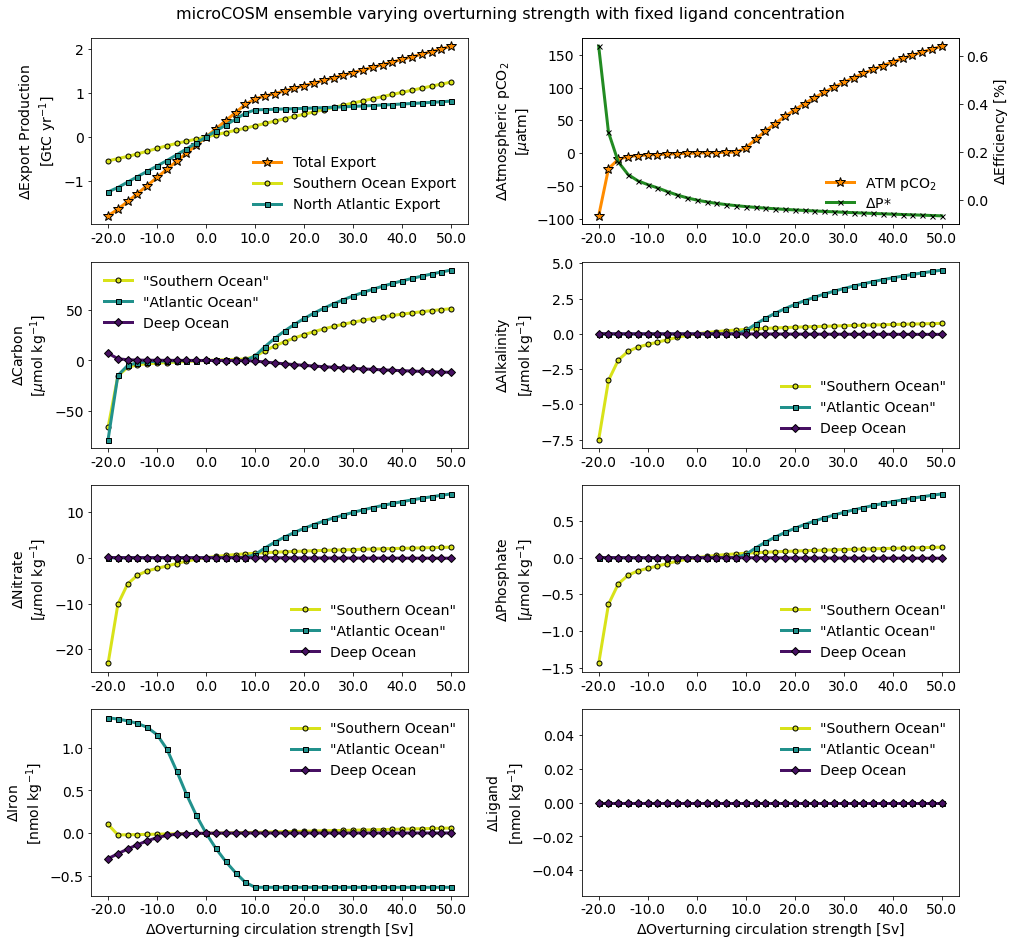

NameError: name 'fnadd' is not defined

In [11]:
# Plot the timeseries of...
ensemble1_anomaly = ensemble1_output.subtract(
    ensemble1_output.loc[ensemble1_output.psi == 20e6].values
)

from matplotlib.ticker import FormatStrFormatter

len_xaxis, len_yaxis = 4, 4  # fix here your numbers
xspace, yspace = 0.9, 0.9  # change the size of the void border here.
x_fig, y_fig = len_xaxis / xspace, len_yaxis / yspace

f1, f1ax = plt.subplots(figsize=(3.5 * x_fig, 3.25 * y_fig), ncols=2, nrows=4)
f1.patch.set_facecolor("None")
mycm = plt.cm.get_cmap("viridis")

f1ax[0, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["tot_export"],
    color           = "darkorange",
    linewidth       = 3,
    marker          = "*",
    markeredgecolor = "k",
    markersize      = 10,
    label           = "Total Export",
)
f1ax[0, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["exportso"],
    color           = mycm(240),
    linewidth       = 3,
    marker          = "o",
    markeredgecolor = "k",
    markersize      = 5,
    label           = "Southern Ocean Export",
)
f1ax[0, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["exportna"],
    color        =mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label="North Atlantic Export",
)
f1ax[0, 0].legend(frameon=False, fontsize=14)
f1ax[0, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[0, 0].set_ylabel("$\Delta$Export Production\n[GtC yr$^{-1}$]", fontsize=14)

f1ax[0, 1].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["atmpco2"],
    color="darkorange",
    linewidth=3,
    marker="*",
    markeredgecolor="k",
    markersize=10,
    label="ATM pCO$_2$",
)
f1ax[0, 1].legend(
    loc="upper left",
    bbox_to_anchor=(0.77, 0.83),
    bbox_transform=f1.transFigure,
    frameon=False,
    fontsize=14,
)
f1ax[0, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[0, 1].set_ylabel("$\Delta$Atmospheric pCO$_2$\n[$\mu$atm]", fontsize=14)
f1ax01b = f1ax[0, 1].twinx()
f1ax01b.plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["pstar"],
    color="forestgreen",
    linewidth=3,
    marker="x",
    markeredgecolor="k",
    markersize=5,
    label="$\Delta$P*",
)
f1ax01b.legend(
    loc="upper left",
    bbox_to_anchor=(0.77, 0.81),
    bbox_transform=f1.transFigure,
    frameon=False,
    fontsize=14,
)
f1ax01b.set_ylabel("$\Delta$Efficiency [%]", fontsize=14)

f1ax[1, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["cso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f1ax[1, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["cna"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f1ax[1, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["cdo"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f1ax[1, 0].legend(frameon=False, fontsize=14)
f1ax[1, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[1, 0].set_ylabel("$\Delta$Carbon\n[$\mu$mol kg$^{-1}$]", fontsize=14)

f1ax[1, 1].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["aso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f1ax[1, 1].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["ana"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f1ax[1, 1].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["ado"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f1ax[1, 1].legend(frameon=False, fontsize=14)
f1ax[1, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[1, 1].set_ylabel("$\Delta$Alkalinity\n[$\mu$mol kg$^{-1}$]", fontsize=14)

f1ax[2, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["nso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f1ax[2, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["nna"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f1ax[2, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["ndo"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f1ax[2, 0].legend(frameon=False, fontsize=14)
f1ax[2, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[2, 0].set_ylabel("$\Delta$Nitrate\n[$\mu$mol kg$^{-1}$]", fontsize=14)

f1ax[2, 1].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["pso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f1ax[2, 1].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["pna"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f1ax[2, 1].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["pdo"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f1ax[2, 1].legend(frameon=False, fontsize=14)
f1ax[2, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[2, 1].set_ylabel("$\Delta$Phosphate\n[$\mu$mol kg$^{-1}$]", fontsize=14)

f1ax[3, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["fso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f1ax[3, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["fna"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f1ax[3, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["fdo"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f1ax[3, 0].legend(frameon=False, fontsize=14)
f1ax[3, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[3, 0].set_ylabel("$\Delta$Iron\n[nmol kg$^{-1}$]", fontsize=14)
f1ax[3, 0].set_xlabel("$\Delta$Overturning circulation strength [Sv]", fontsize=14)

f1ax[3, 1].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["lso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f1ax[3, 1].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["lna"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f1ax[3, 1].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["ldo"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f1ax[3, 1].legend(frameon=False, fontsize=14)
f1ax[3, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[3, 1].set_ylabel("$\Delta$Ligand\n[nmol kg$^{-1}$]", fontsize=14)
f1ax[3, 1].set_xlabel("$\Delta$Overturning circulation strength [Sv]", fontsize=14)

plt.suptitle(
    "microCOSM ensemble varying overturning strength with fixed ligand concentration",
    fontsize=16,
)
# Can adjust the subplot size
plt.subplots_adjust(wspace=0.3, top=0.95)
plt.show()

# save the graph
f1.savefig(
    "microCOSM_" + fnadd + "_ensemble_psi_{:.0f}Sv".format(psi_max) + ".pdf",
    format="pdf",
    facecolor=f1.get_facecolor(),
    edgecolor="none",
    bbox_inches="tight",
)
plt.close()

Load previous model runs and plot uncertainty ranges

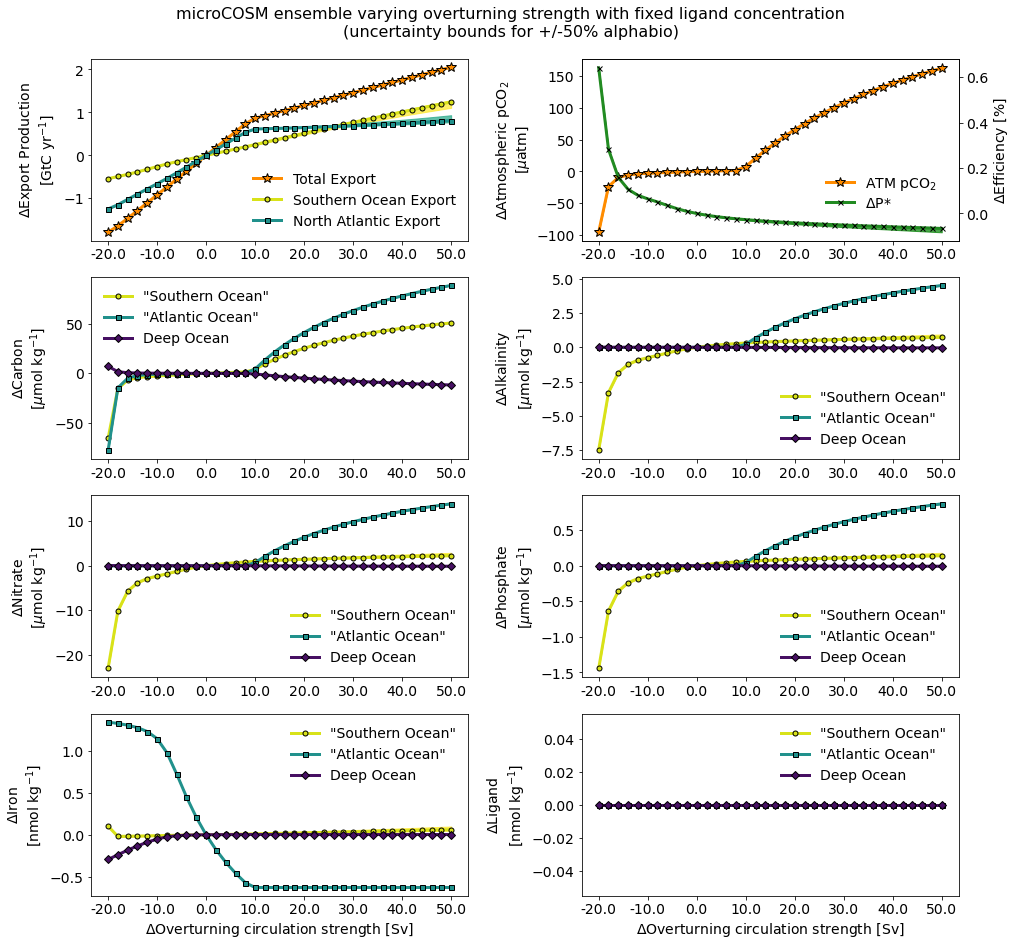

In [8]:
# Load steady state values from before
ensemble1_deca = pd.read_json(
    "run_microCOSM_decafixedlt2nm_psi_{:.0f}Sv".format(psi_max) + "_output.json"
)#.rename(columns={"export1":"exportso","export2":"exportna"})
ensemble1_inca = pd.read_json(
    "run_microCOSM_incafixedlt2nm_psi_{:.0f}Sv".format(psi_max) + "_output.json"
)#.rename(columns={"export1":"exportso","export2":"exportna"})

ensemble1_deca_anomaly = ensemble1_deca.subtract(
    ensemble1_deca.loc[ensemble1_deca.psi == 20e6].values
)
ensemble1_inca_anomaly = ensemble1_inca.subtract(
    ensemble1_inca.loc[ensemble1_inca.psi == 20e6].values
)

f1a, f1aax = plt.subplots(figsize=(3.5 * x_fig, 3.25 * y_fig), ncols=2, nrows=4)
f1a.patch.set_facecolor("None")
mycm = plt.cm.get_cmap("viridis")

alpha = 0.7

f1aax[0, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["tot_export"],
    color="darkorange",
    linewidth=3,
    marker="*",
    markeredgecolor="k",
    markersize=10,
    label="Total Export",
)
f1aax[0, 0].fill_between(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_deca_anomaly["tot_export"],
    ensemble1_inca_anomaly["tot_export"],
    color="orange",
    alpha=alpha,
)
f1aax[0, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["exportso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label="Southern Ocean Export",
)
f1aax[0, 0].fill_between(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_deca_anomaly["exportso"],
    ensemble1_inca_anomaly["exportso"],
    color=mycm(256),
    alpha=alpha,
)
f1aax[0, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["exportna"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label="North Atlantic Export",
)
f1aax[0, 0].fill_between(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_deca_anomaly["exportna"],
    ensemble1_inca_anomaly["exportna"],
    color=mycm(150),
    alpha=alpha,
)
f1aax[0, 0].legend(frameon=False, fontsize=14)
f1aax[0, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1aax[0, 0].set_ylabel("$\Delta$Export Production\n[GtC yr$^{-1}$]", fontsize=14)

f1aax[0, 1].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["atmpco2"],
    color="darkorange",
    linewidth=3,
    marker="*",
    markeredgecolor="k",
    markersize=10,
    label="ATM pCO$_2$",
)
f1aax[0, 1].fill_between(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_deca_anomaly["atmpco2"],
    ensemble1_inca_anomaly["atmpco2"],
    color="orange",
    alpha=alpha,
)
f1aax[0, 1].legend(
    loc="upper left",
    bbox_to_anchor=(0.77, 0.83),
    bbox_transform=f1a.transFigure,
    frameon=False,
    fontsize=14,
)
f1aax[0, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1aax[0, 1].set_ylabel("$\Delta$Atmospheric pCO$_2$\n[$\mu$atm]", fontsize=14)
f1aax01b = f1aax[0, 1].twinx()
f1aax01b.plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["pstar"],
    color="forestgreen",
    linewidth=3,
    marker="x",
    markeredgecolor="k",
    markersize=5,
    label="$\Delta$P*",
)
f1aax01b.fill_between(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_deca_anomaly["pstar"],
    ensemble1_inca_anomaly["pstar"],
    color="green",
    alpha=alpha,
)
f1aax01b.legend(
    loc="upper left",
    bbox_to_anchor=(0.77, 0.81),
    bbox_transform=f1a.transFigure,
    frameon=False,
    fontsize=14,
)
f1aax01b.set_ylabel("$\Delta$Efficiency [%]", fontsize=14)

f1aax[1, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["cso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f1aax[1, 0].fill_between(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_deca_anomaly["cso"],
    ensemble1_inca_anomaly["cso"],
    color=mycm(256),
    alpha=alpha,
)
f1aax[1, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["cna"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f1aax[1, 0].fill_between(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_deca_anomaly["cna"],
    ensemble1_inca_anomaly["cna"],
    color=mycm(150),
    alpha=alpha,
)
f1aax[1, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["cdo"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f1aax[1, 0].fill_between(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_deca_anomaly["cdo"],
    ensemble1_inca_anomaly["cdo"],
    color=mycm(50),
    alpha=alpha,
)
f1aax[1, 0].legend(frameon=False, fontsize=14)
f1aax[1, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1aax[1, 0].set_ylabel("$\Delta$Carbon\n[$\mu$mol kg$^{-1}$]", fontsize=14)

f1aax[1, 1].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["aso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f1aax[1, 1].fill_between(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_deca_anomaly["aso"],
    ensemble1_inca_anomaly["aso"],
    color=mycm(256),
    alpha=alpha,
)
f1aax[1, 1].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["ana"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f1aax[1, 1].fill_between(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_deca_anomaly["ana"],
    ensemble1_inca_anomaly["ana"],
    color=mycm(150),
    alpha=alpha,
)
f1aax[1, 1].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["ado"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f1aax[1, 1].fill_between(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_deca_anomaly["ado"],
    ensemble1_inca_anomaly["ado"],
    color=mycm(50),
    alpha=alpha,
)
f1aax[1, 1].legend(frameon=False, fontsize=14)
f1aax[1, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1aax[1, 1].set_ylabel("$\Delta$Alkalinity\n[$\mu$mol kg$^{-1}$]", fontsize=14)

f1aax[2, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["nso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f1aax[2, 0].fill_between(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_deca_anomaly["nso"],
    ensemble1_inca_anomaly["nso"],
    color=mycm(256),
    alpha=alpha,
)
f1aax[2, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["nna"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f1aax[2, 0].fill_between(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_deca_anomaly["nna"],
    ensemble1_inca_anomaly["nna"],
    color=mycm(150),
    alpha=alpha,
)
f1aax[2, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["ndo"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f1aax[2, 0].fill_between(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_deca_anomaly["ndo"],
    ensemble1_inca_anomaly["ndo"],
    color=mycm(50),
    alpha=alpha,
)
f1aax[2, 0].legend(frameon=False, fontsize=14)
f1aax[2, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1aax[2, 0].set_ylabel("$\Delta$Nitrate\n[$\mu$mol kg$^{-1}$]", fontsize=14)

f1aax[2, 1].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["pso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f1aax[2, 1].fill_between(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_deca_anomaly["pso"],
    ensemble1_inca_anomaly["pso"],
    color=mycm(256),
    alpha=alpha,
)
f1aax[2, 1].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["pna"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f1aax[2, 1].fill_between(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_deca_anomaly["pna"],
    ensemble1_inca_anomaly["pna"],
    color=mycm(150),
    alpha=alpha,
)
f1aax[2, 1].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["pdo"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f1aax[2, 1].fill_between(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_deca_anomaly["pdo"],
    ensemble1_inca_anomaly["pdo"],
    color=mycm(50),
    alpha=alpha,
)
f1aax[2, 1].legend(frameon=False, fontsize=14)
f1aax[2, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1aax[2, 1].set_ylabel("$\Delta$Phosphate\n[$\mu$mol kg$^{-1}$]", fontsize=14)

f1aax[3, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["fso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f1aax[3, 0].fill_between(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_deca_anomaly["fso"],
    ensemble1_inca_anomaly["fso"],
    color=mycm(256),
    alpha=alpha,
)
f1aax[3, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["fna"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f1aax[3, 0].fill_between(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_deca_anomaly["fna"],
    ensemble1_inca_anomaly["fna"],
    color=mycm(150),
    alpha=alpha,
)
f1aax[3, 0].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["fdo"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f1aax[3, 0].fill_between(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_deca_anomaly["fdo"],
    ensemble1_inca_anomaly["fdo"],
    color=mycm(50),
    alpha=alpha,
)
f1aax[3, 0].legend(frameon=False, fontsize=14)
f1aax[3, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1aax[3, 0].set_ylabel("$\Delta$Iron\n[nmol kg$^{-1}$]", fontsize=14)
f1aax[3, 0].set_xlabel("$\Delta$Overturning circulation strength [Sv]", fontsize=14)

f1aax[3, 1].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["lso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f1aax[3, 1].fill_between(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_deca_anomaly["lso"],
    ensemble1_inca_anomaly["lso"],
    color=mycm(256),
    alpha=alpha,
)
f1aax[3, 1].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["lna"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f1aax[3, 1].fill_between(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_deca_anomaly["lna"],
    ensemble1_inca_anomaly["lna"],
    color=mycm(150),
    alpha=alpha,
)
f1aax[3, 1].plot(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_anomaly["ldo"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f1aax[3, 1].fill_between(
    ensemble1_anomaly["psi"] * 1e-6,
    ensemble1_deca_anomaly["ldo"],
    ensemble1_inca_anomaly["ldo"],
    color=mycm(50),
    alpha=alpha,
)
f1aax[3, 1].legend(frameon=False, fontsize=14)
f1aax[3, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1aax[3, 1].set_ylabel("$\Delta$Ligand\n[nmol kg$^{-1}$]", fontsize=14)
f1aax[3, 1].set_xlabel("$\Delta$Overturning circulation strength [Sv]", fontsize=14)

plt.suptitle(
    "microCOSM ensemble varying overturning strength with fixed ligand concentration\n(uncertainty bounds for +/-50% alphabio)",
    fontsize=16,
)
# Can adjust the subplot size
plt.subplots_adjust(wspace=0.3, top=0.93)
plt.show()

# save the graph
f1a.savefig(
    "microCOSM_"
    + fnadd
    + "_ensemble_psi_{:.0f}Sv_uncertainty".format(psi_max)
    + ".pdf",
    format="pdf",
    facecolor=f1a.get_facecolor(),
    edgecolor="none",
    bbox_inches="tight",
)
plt.close()

Now, we'll run the same ensemble but with variable ligand concentrations

In [9]:
fnadd = fadd + "variablelt"

# Load steady state values from before
model_input = pd.read_json("run_microCOSM_" + fnadd + "_pickup.json", typ='series').to_frame()

# repeat the input parameters and adjust for the ensemble run
ensemble2_input = pd.concat([model_input.T] * niters, ignore_index=True, copy=True)

ensemble2_input["nyrs"]  = 1e4
ensemble2_input["tout"]  = 10
ensemble2_input["psi"]   = psi_var
ensemble2_input["niter"] = niter

ensemble2_input.to_json(
    "run_microCOSM_" + fnadd + "_psi_{:.0f}Sv".format(psi_max) + "_input.json"
)
ensemble2_input.iloc[0]

niter                                                         0
nyrs                                                    10000.0
tout                                                         10
nout                                                     1001.0
dx                         [17000000.0, 17000000.0, 17000000.0]
dy                          [3000000.0, 13000000.0, 16000000.0]
dz                                         [50.0, 50.0, 5050.0]
Kmix          [[0.0, 1.0, 1.0], [1.0, 0.0, 1.0], [1.0, 1.0, ...
Rremin        [[-1.0, 0.0, 0.0], [0.0, -1.0, 0.0], [1.0, 1.0...
Pcir          [[0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.0, 1.0, ...
psi                                                         0.0
dif                                                   1000000.0
alphabio                                               0.000006
gamma                                                    0.0053
lambda                                               87960000.0
dlambdadz                               

Run the experiment

In [10]:
start = time.time()
if run_in_parallel:  # about 40s on 8 core late 2013 iMac i7 3.5Ghz
    # Run in parallel using pkg/pandarallel's "parallel_apply"
    import multiprocessing

    ensemble2_output = run_microcosm(
        ensemble2_input, workers=multiprocessing.cpu_count()
    )
else:  # about 3 mins in serial
    # OR in series using pandas' "apply" to run through rows of a data frame of inputs
    ensemble2_output = run_microcosm(ensemble2_input, workers=1)
end = time.time()
print("{0} seconds".format((end - start)))

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


105.37438011169434 seconds


In [11]:
# save the output
ensemble2_output.to_json(
    "run_microCOSM_" + fnadd + "_psi_{:.0f}Sv".format(psi_max) + "_output.json"
)

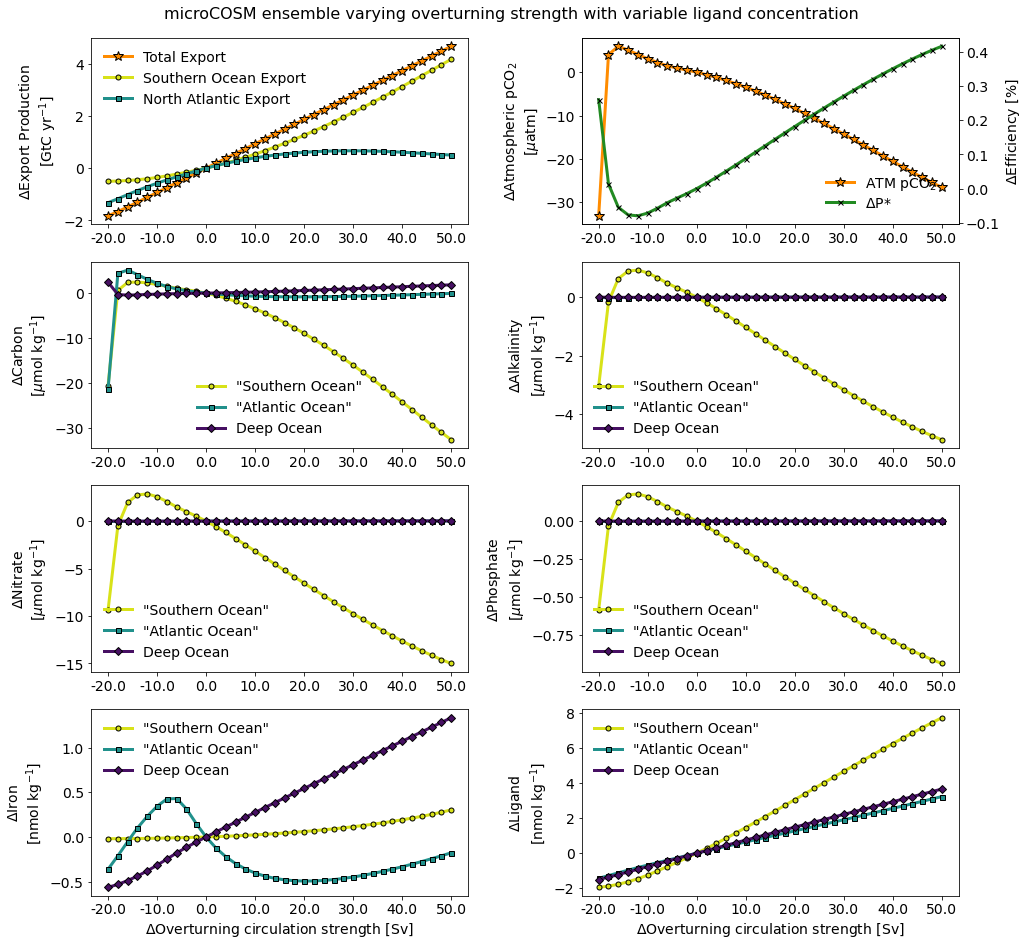

In [12]:
# Plot the timeseries of...
ensemble2_anomaly = ensemble2_output.subtract(
    ensemble2_output.loc[ensemble2_output.psi == 20e6].values
)

f2, f2ax = plt.subplots(figsize=(3.5 * x_fig, 3.25 * y_fig), ncols=2, nrows=4)
f2.patch.set_facecolor("None")
mycm = plt.cm.get_cmap("viridis")

f2ax[0, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["tot_export"],
    color="darkorange",
    linewidth=3,
    marker="*",
    markeredgecolor="k",
    markersize=10,
    label="Total Export",
)
f2ax[0, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["exportso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label="Southern Ocean Export",
)
f2ax[0, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["exportna"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label="North Atlantic Export",
)
f2ax[0, 0].legend(frameon=False, fontsize=14)
f2ax[0, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[0, 0].set_ylabel("$\Delta$Export Production\n[GtC yr$^{-1}$]", fontsize=14)

f2ax[0, 1].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["atmpco2"],
    color="darkorange",
    linewidth=3,
    marker="*",
    markeredgecolor="k",
    markersize=10,
    label="ATM pCO$_2$",
)
f2ax[0, 1].legend(
    loc="upper left",
    bbox_to_anchor=(0.77, 0.83),
    bbox_transform=f2.transFigure,
    frameon=False,
    fontsize=14,
)
f2ax[0, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[0, 1].set_ylabel("$\Delta$Atmospheric pCO$_2$\n[$\mu$atm]", fontsize=14)
f2ax01b = f2ax[0, 1].twinx()
f2ax01b.plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["pstar"],
    color="forestgreen",
    linewidth=3,
    marker="x",
    markeredgecolor="k",
    markersize=5,
    label="$\Delta$P*",
)
f2ax01b.legend(
    loc="upper left",
    bbox_to_anchor=(0.77, 0.81),
    bbox_transform=f2.transFigure,
    frameon=False,
    fontsize=14,
)
f2ax01b.set_ylabel("$\Delta$Efficiency [%]", fontsize=14)

f2ax[1, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["cso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f2ax[1, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["cna"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f2ax[1, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["cdo"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f2ax[1, 0].legend(frameon=False, fontsize=14)
f2ax[1, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[1, 0].set_ylabel("$\Delta$Carbon\n[$\mu$mol kg$^{-1}$]", fontsize=14)

f2ax[1, 1].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["aso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f2ax[1, 1].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["ana"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f2ax[1, 1].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["ado"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f2ax[1, 1].legend(frameon=False, fontsize=14)
f2ax[1, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[1, 1].set_ylabel("$\Delta$Alkalinity\n[$\mu$mol kg$^{-1}$]", fontsize=14)

f2ax[2, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["nso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f2ax[2, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["nna"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f2ax[2, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["ndo"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f2ax[2, 0].legend(frameon=False, fontsize=14)
f2ax[2, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[2, 0].set_ylabel("$\Delta$Nitrate\n[$\mu$mol kg$^{-1}$]", fontsize=14)

f2ax[2, 1].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["pso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f2ax[2, 1].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["pna"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f2ax[2, 1].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["pdo"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f2ax[2, 1].legend(frameon=False, fontsize=14)
f2ax[2, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[2, 1].set_ylabel("$\Delta$Phosphate\n[$\mu$mol kg$^{-1}$]", fontsize=14)

f2ax[3, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["fso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f2ax[3, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["fna"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f2ax[3, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["fdo"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f2ax[3, 0].legend(frameon=False, fontsize=14)
f2ax[3, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[3, 0].set_ylabel("$\Delta$Iron\n[nmol kg$^{-1}$]", fontsize=14)
f2ax[3, 0].set_xlabel("$\Delta$Overturning circulation strength [Sv]", fontsize=14)

f2ax[3, 1].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["lso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f2ax[3, 1].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["lna"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f2ax[3, 1].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["ldo"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f2ax[3, 1].legend(frameon=False, fontsize=14)
f2ax[3, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[3, 1].set_ylabel("$\Delta$Ligand\n[nmol kg$^{-1}$]", fontsize=14)
f2ax[3, 1].set_xlabel("$\Delta$Overturning circulation strength [Sv]", fontsize=14)

plt.suptitle(
    "microCOSM ensemble varying overturning strength with variable ligand concentration",
    fontsize=16,
)
# Can adjust the subplot size
plt.subplots_adjust(wspace=0.3, top=0.95)
plt.show()

# save the graph
f2.savefig(
    "microCOSM_" + fnadd + "_ensemble_psi_{:.0f}Sv".format(psi_max) + ".pdf",
    format="pdf",
    facecolor=f2.get_facecolor(),
    edgecolor="none",
    bbox_inches="tight",
)
plt.close()

Load previous model runs and plot uncertainty

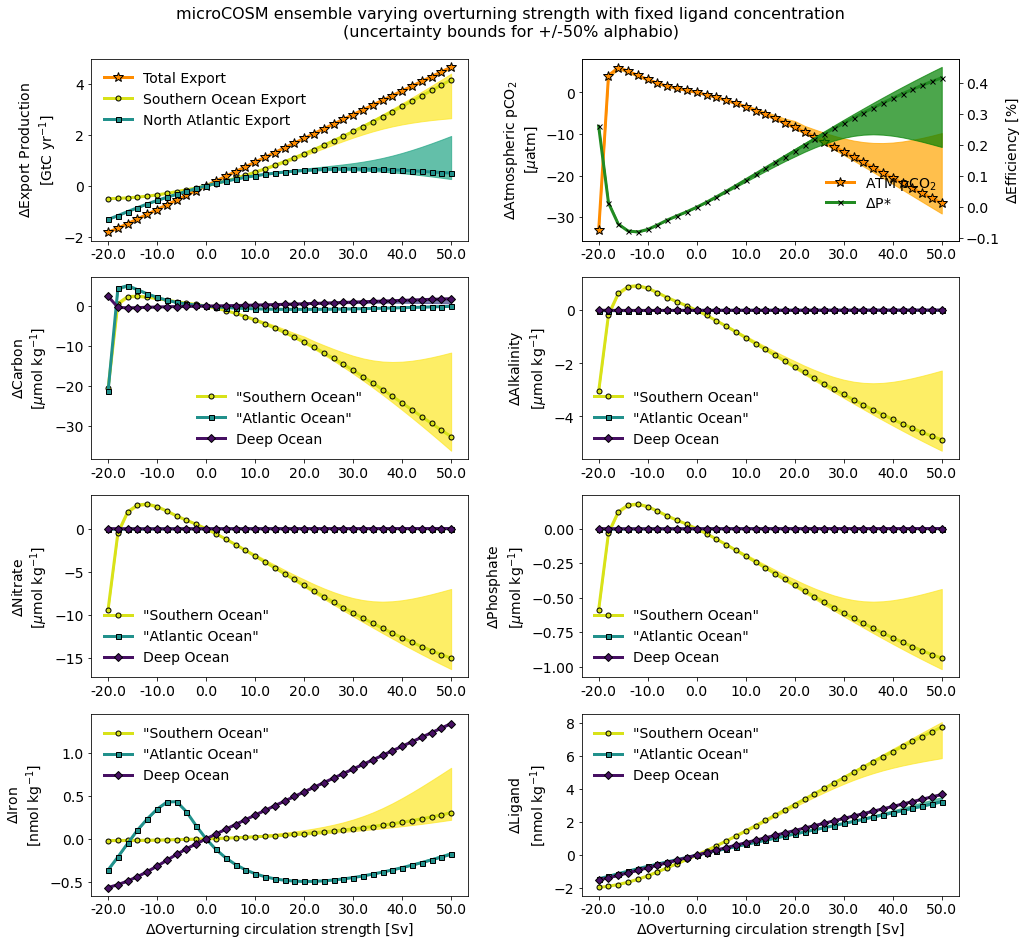

In [13]:
# Load steady state values from before
ensemble2_deca = pd.read_json(
    "run_microCOSM_decavariablelt_psi_{:.0f}Sv".format(psi_max) + "_output.json"
)#.rename(columns={"export1":"exportso","export2":"exportna"})
ensemble2_inca = pd.read_json(
    "run_microCOSM_incavariablelt_psi_{:.0f}Sv".format(psi_max) + "_output.json"
)#.rename(columns={"export1":"exportso","export2":"exportna"})


ensemble2_deca = pd.read_json(
    "run_microCOSM_decavariablelt_psi_{:.0f}Sv".format(psi_max) + "_output.json"
)
ensemble2_inca = pd.read_json(
    "run_microCOSM_incavariablelt_psi_{:.0f}Sv".format(psi_max) + "_output.json"
)

ensemble2_deca_anomaly = ensemble2_deca.subtract(
    ensemble2_deca.loc[ensemble2_deca.psi == 20e6].values
)
ensemble2_inca_anomaly = ensemble2_inca.subtract(
    ensemble2_inca.loc[ensemble2_inca.psi == 20e6].values
)

f2a, f2aax = plt.subplots(figsize=(3.5 * x_fig, 3.25 * y_fig), ncols=2, nrows=4)
f2a.patch.set_facecolor("None")
mycm = plt.cm.get_cmap("viridis")

alpha = 0.7

f2aax[0, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["tot_export"],
    color="darkorange",
    linewidth=3,
    marker="*",
    markeredgecolor="k",
    markersize=10,
    label="Total Export",
)
f2aax[0, 0].fill_between(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_deca_anomaly["tot_export"],
    ensemble2_inca_anomaly["tot_export"],
    color="orange",
    alpha=alpha,
)
f2aax[0, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["exportso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label="Southern Ocean Export",
)
f2aax[0, 0].fill_between(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_deca_anomaly["exportso"],
    ensemble2_inca_anomaly["exportso"],
    color=mycm(256),
    alpha=alpha,
)
f2aax[0, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["exportna"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label="North Atlantic Export",
)
f2aax[0, 0].fill_between(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_deca_anomaly["exportna"],
    ensemble2_inca_anomaly["exportna"],
    color=mycm(150),
    alpha=alpha,
)
f2aax[0, 0].legend(frameon=False, fontsize=14)
f2aax[0, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2aax[0, 0].set_ylabel("$\Delta$Export Production\n[GtC yr$^{-1}$]", fontsize=14)

f2aax[0, 1].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["atmpco2"],
    color="darkorange",
    linewidth=3,
    marker="*",
    markeredgecolor="k",
    markersize=10,
    label="ATM pCO$_2$",
)
f2aax[0, 1].fill_between(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_deca_anomaly["atmpco2"],
    ensemble2_inca_anomaly["atmpco2"],
    color="orange",
    alpha=alpha,
)
f2aax[0, 1].legend(
    loc="upper left",
    bbox_to_anchor=(0.77, 0.83),
    bbox_transform=f2a.transFigure,
    frameon=False,
    fontsize=14,
)
f2aax[0, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2aax[0, 1].set_ylabel("$\Delta$Atmospheric pCO$_2$\n[$\mu$atm]", fontsize=14)
f2aax01b = f2aax[0, 1].twinx()
f2aax01b.plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["pstar"],
    color="forestgreen",
    linewidth=3,
    marker="x",
    markeredgecolor="k",
    markersize=5,
    label="$\Delta$P*",
)
f2aax01b.fill_between(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_deca_anomaly["pstar"],
    ensemble2_inca_anomaly["pstar"],
    color="green",
    alpha=alpha,
)
f2aax01b.legend(
    loc="upper left",
    bbox_to_anchor=(0.77, 0.81),
    bbox_transform=f2a.transFigure,
    frameon=False,
    fontsize=14,
)
f2aax01b.set_ylabel("$\Delta$Efficiency [%]", fontsize=14)

f2aax[1, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["cso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f2aax[1, 0].fill_between(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_deca_anomaly["cso"],
    ensemble2_inca_anomaly["cso"],
    color=mycm(256),
    alpha=alpha,
)
f2aax[1, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["cna"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f2aax[1, 0].fill_between(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_deca_anomaly["cna"],
    ensemble2_inca_anomaly["cna"],
    color=mycm(150),
    alpha=alpha,
)
f2aax[1, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["cdo"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f2aax[1, 0].fill_between(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_deca_anomaly["cdo"],
    ensemble2_inca_anomaly["cdo"],
    color=mycm(50),
    alpha=alpha,
)
f2aax[1, 0].legend(frameon=False, fontsize=14)
f2aax[1, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2aax[1, 0].set_ylabel("$\Delta$Carbon\n[$\mu$mol kg$^{-1}$]", fontsize=14)

f2aax[1, 1].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["aso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f2aax[1, 1].fill_between(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_deca_anomaly["aso"],
    ensemble2_inca_anomaly["aso"],
    color=mycm(256),
    alpha=alpha,
)
f2aax[1, 1].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["ana"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f2aax[1, 1].fill_between(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_deca_anomaly["ana"],
    ensemble2_inca_anomaly["ana"],
    color=mycm(150),
    alpha=alpha,
)
f2aax[1, 1].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["ado"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f2aax[1, 1].fill_between(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_deca_anomaly["ado"],
    ensemble2_inca_anomaly["ado"],
    color=mycm(50),
    alpha=alpha,
)
f2aax[1, 1].legend(frameon=False, fontsize=14)
f2aax[1, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2aax[1, 1].set_ylabel("$\Delta$Alkalinity\n[$\mu$mol kg$^{-1}$]", fontsize=14)

f2aax[2, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["nso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f2aax[2, 0].fill_between(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_deca_anomaly["nso"],
    ensemble2_inca_anomaly["nso"],
    color=mycm(256),
    alpha=alpha,
)
f2aax[2, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["nna"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f2aax[2, 0].fill_between(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_deca_anomaly["nna"],
    ensemble2_inca_anomaly["nna"],
    color=mycm(150),
    alpha=alpha,
)
f2aax[2, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["ndo"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f2aax[2, 0].fill_between(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_deca_anomaly["ndo"],
    ensemble2_inca_anomaly["ndo"],
    color=mycm(50),
    alpha=alpha,
)
f2aax[2, 0].legend(frameon=False, fontsize=14)
f2aax[2, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2aax[2, 0].set_ylabel("$\Delta$Nitrate\n[$\mu$mol kg$^{-1}$]", fontsize=14)

f2aax[2, 1].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["pso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f2aax[2, 1].fill_between(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_deca_anomaly["pso"],
    ensemble2_inca_anomaly["pso"],
    color=mycm(256),
    alpha=alpha,
)
f2aax[2, 1].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["pna"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f2aax[2, 1].fill_between(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_deca_anomaly["pna"],
    ensemble2_inca_anomaly["pna"],
    color=mycm(150),
    alpha=alpha,
)
f2aax[2, 1].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["pdo"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f2aax[2, 1].fill_between(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_deca_anomaly["pdo"],
    ensemble2_inca_anomaly["pdo"],
    color=mycm(50),
    alpha=alpha,
)
f2aax[2, 1].legend(frameon=False, fontsize=14)
f2aax[2, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2aax[2, 1].set_ylabel("$\Delta$Phosphate\n[$\mu$mol kg$^{-1}$]", fontsize=14)

f2aax[3, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["fso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f2aax[3, 0].fill_between(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_deca_anomaly["fso"],
    ensemble2_inca_anomaly["fso"],
    color=mycm(256),
    alpha=alpha,
)
f2aax[3, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["fna"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f2aax[3, 0].fill_between(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_deca_anomaly["fna"],
    ensemble2_inca_anomaly["fna"],
    color=mycm(150),
    alpha=alpha,
)
f2aax[3, 0].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["fdo"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f2aax[3, 0].fill_between(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_deca_anomaly["fdo"],
    ensemble2_inca_anomaly["fdo"],
    color=mycm(50),
    alpha=alpha,
)
f2aax[3, 0].legend(frameon=False, fontsize=14)
f2aax[3, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2aax[3, 0].set_ylabel("$\Delta$Iron\n[nmol kg$^{-1}$]", fontsize=14)
f2aax[3, 0].set_xlabel("$\Delta$Overturning circulation strength [Sv]", fontsize=14)

f2aax[3, 1].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["lso"],
    color=mycm(240),
    linewidth=3,
    marker="o",
    markeredgecolor="k",
    markersize=5,
    label='"Southern Ocean"',
)
f2aax[3, 1].fill_between(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_deca_anomaly["lso"],
    ensemble2_inca_anomaly["lso"],
    color=mycm(256),
    alpha=alpha,
)
f2aax[3, 1].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["lna"],
    color=mycm(128),
    linewidth=3,
    marker="s",
    markeredgecolor="k",
    markersize=5,
    label='"Atlantic Ocean"',
)
f2aax[3, 1].fill_between(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_deca_anomaly["lna"],
    ensemble2_inca_anomaly["lna"],
    color=mycm(150),
    alpha=alpha,
)
f2aax[3, 1].plot(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_anomaly["ldo"],
    color=mycm(10),
    linewidth=3,
    marker="D",
    markeredgecolor="k",
    markersize=5,
    label="Deep Ocean",
)
f2aax[3, 1].fill_between(
    ensemble2_anomaly["psi"] * 1e-6,
    ensemble2_deca_anomaly["ldo"],
    ensemble2_inca_anomaly["ldo"],
    color=mycm(50),
    alpha=alpha,
)
f2aax[3, 1].legend(frameon=False, fontsize=14)
f2aax[3, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2aax[3, 1].set_ylabel("$\Delta$Ligand\n[nmol kg$^{-1}$]", fontsize=14)
f2aax[3, 1].set_xlabel("$\Delta$Overturning circulation strength [Sv]", fontsize=14)

plt.suptitle(
    "microCOSM ensemble varying overturning strength with fixed ligand concentration\n(uncertainty bounds for +/-50% alphabio)",
    fontsize=16,
)
# Can adjust the subplot size
plt.subplots_adjust(wspace=0.3, top=0.93)
plt.show()

# save the graph
f2a.savefig(
    "microCOSM_"
    + fnadd
    + "_ensemble_psi_{:.0f}Sv_uncertainty".format(psi_max)
    + ".pdf",
    format="pdf",
    facecolor=f2a.get_facecolor(),
    edgecolor="none",
    bbox_inches="tight",
)
plt.close()